In [1]:
# standard Python packages for scientific computing:
import numpy as np  # Numerical Python
import matplotlib.pyplot as plt  # plotting
import math as m
import os  # operating system / file utilities

    
# from numba import jit
# first did "conda install numba".  See
# https://numba.readthedocs.io/en/stable/user/5minguide.html

In [2]:
# default figure size okay if notebook is zoomed for class presentation:
# plt.rcParams["figure.figsize"] = [6.4, 4.8] # default
plt.rcParams["figure.figsize"] = [8.0, 6.0]

In [3]:
# create a subdirectory to hold figures
# (if it doesn't exist already)
os.makedirs("../figs", exist_ok=True)

## Simple advection problem

In [4]:
def init_smooth(N):
    # created the grid
    x = np.linspace(0, 1, N+1)
    x = (x[0:-1] + x[1:]) / 2
    u = np.zeros(np.size(x))
    
    # set initial conditions
    u = 1 * np.exp(- (x-0.3) ** 2 / 0.07 ** 2)
    
    return x, u

In [5]:
def init_step(N):
    # created the grid
    x = np.linspace(0, 1, N+1)
    x = (x[0:-1] + x[1:]) / 2
    u = np.zeros(np.size(x))
    
    # set initial conditions
    u = 1 * np.exp(- (x-0.3) ** 2 / 0.07 ** 2)
    where = np.where(np.abs(x-0.7) <= 0.1)[0]
    u[where] = 1

    return x, u

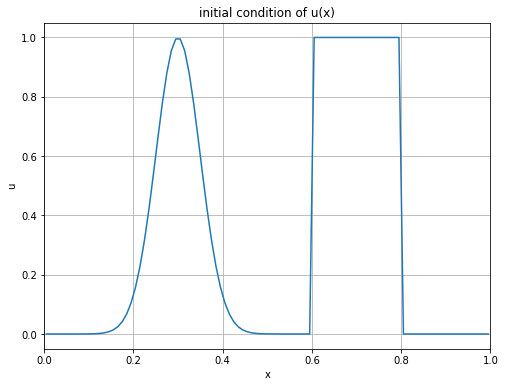

In [6]:
# creating grid
N = 100
x = np.linspace(0,1,N+1)
x = (x[0:-1] + x[1:]) / 2
u = np.zeros(np.size(x))

# set initial conditions
u = 1 * np.exp(- (x-0.3) ** 2 / 0.07 ** 2)
where = np.where(np.abs(x-0.7) <= 0.1)[0]
u[where] = 1

# plot
plt.plot(x,u)
plt.xlabel('x')
plt.ylabel('u')
plt.title('initial condition of u(x)')
plt.xlim(0,1)
plt.grid()
plt.show()

### Finite volume method
#### 2nd order centered differencing

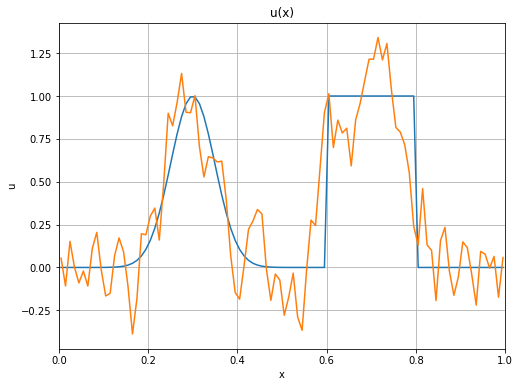

In [7]:
# advect
c = 1
dx = 1/N
dt = 0.01 * dx

N_steps = 1 / c / dt

u_next = u
for jj in range(int(N_steps)):
    # flux
    u_mod = np.insert(u_next, (0, N), (u_next[-1], u_next[0]), axis = 0)
    f = c * 0.5 * (u_mod[0:-1] + u_mod[1:])

    # update the system
    u_next = u_next - (dt / dx) * (f[1:] - f[0:-1])

# plot result
# plot
plt.plot(x,u)
plt.plot(x,u_next)
plt.xlabel('x')
plt.ylabel('u')
plt.title('u(x)')
plt.xlim(0,1)
plt.grid()
plt.show()

In [49]:
b = np.array([1,2,3,4])
np.insert(b, , 5, axis = 0)

array([5, 1, 2, 3, 4])

In [78]:
# should a flux function be a member of "spatial-scheme" class e.g. 2nd-central, 1st-upwind etc.
# what about limiter

#### 1st-3rd order upwind differencing

In [42]:
# general function to advect
def advect(x, u, c, dt, n_steps, flux_method, step_method):
    for ii in range(n_steps):
        # march in time
        u = step_method(x, u, flux_method, c, dt)
        
    return u

In [134]:
# 1st order upwind differencing
# equivalent to Godunov's Algorithm with piecewise constant
def first_order_upwind(x, u, c):
    f = c * u
    return f

# 2nd order centered differencing
def second_order_centered(x, u, c):
    f = c * (u + np.roll(u, -1)) / 2
    return f

# 2nd order upwind differencing
def second_order_upwind(x, u, c):
    f = c * (u + 0.5 * (u - np.roll(u, 1)))
    return f

# 3rd order upwind biased differencing
def third_order_upwind(x, u, c):
    u_left = np.roll(u, 1)
    u_right = np.roll(u, -1)
    f = c * (u + 1/4 * (u_right - u_left) + 1/12 * (u_right - 2 * u + u_left))
    return f

# 4th order centered differencing
def fourth_order_centered(x, u, c):
    f = c * (7/12 * (u + np.roll(u, -1)) - \
             1/12 * (np.roll(u, 1) + np.roll(u, -2)))
    return f

In [118]:
def minmin(x, y, z = None):
    m = 1/2 * (x + y) - 1/2 * np.sign(x - y) * (x - y)
    if z is None:
        return m
    else:
        n = 1/2 * (m + z) - 1/2 * np.sign(m - z) * (m - z)
        return n

In [123]:
def minmod(x, y, z = None):
    if z is None:
        return 0.5 * (np.sign(x) + np.sign(y)) * minmin(np.abs(x), np.abs(y))
    else:
        return 0.25 * (np.sign(x) + np.sign(y)) * np.abs(np.sign(y) + np.sign(z)) * \
               minmin(np.abs(x), np.abs(y), np.abs(z))

In [17]:
def median(x, y, z):
    return x + minmod(y - x, z - x)

In [131]:
# limiters
# intermediate complexity advection 5-point stencil
def ICA5(x, u, c):
    # Eq 2.12 Suresh and Huynh (1997)
    alpha = 4
    # limiters
    u1 = fourth_order_centered(x, u, c) / c
    uMPL = u + minmod(np.roll(u, -1) - u, alpha * (u - np.roll(u, 1)))
    uL = median(u1, u, uMPL)
    uMPR = np.roll(u, -1) + minmod(u - np.roll(u, -1), \
                                   alpha * (np.roll(u, -1) - np.roll(u, -2)))
    uR = median(u1, np.roll(u, -1), uMPR)
    
    # Rusanov's flux
    f = c/2 * (uL + uR) - np.abs(c)/2 * (uR - uL)
    
    return f

In [43]:
# forward euler
def forward_euler(x, u, flux_method, c, dt):
    # here assume uniform grid
    dx = x[1] - x[0]
    
    # compute flux
    f = flux_method(x, u, c)
    u_next = u - (dt / dx) * (f - np.roll(f, 1))
    return u_next

In [49]:
# Suresh and Huynh (1997)
def RK3(x, u, flux_method, c, dt):
    # here assume uniform grid
    dx = x[1] - x[0]
    
    # CFL Number
    # cfl = c * dt / dx
    
    w0 = u
    f0 = flux_method(x, w0, c)
    w1 = w0 + (dt / dx) * (- f0 + np.roll(f0, 1))
    f1 = flux_method(x, w1, c)
    w2 = 3/4 * w0 + 1/4 * (w1 + (dt / dx) * (- f1 + np.roll(f1, 1)))
    f2 = flux_method(x, w2, c)
    w3 = 1/3 * w0 + 2/3 * (w2 + (dt / dx) * (- f2 + np.roll(f2, 1)))
    u_next = w3
    return u_next

### Test with Forward Euler scheme

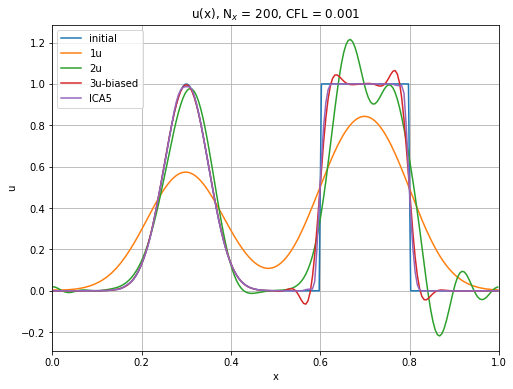

In [136]:
N = 200
x, u = init_step(N)

# advect
c = 1
dx = 1/N
dt = 0.001 * dx / c
N_steps = int(1 / c / dt)

u_1u = advect(x, u, c, dt, N_steps, first_order_upwind, forward_euler)
u_2u = advect(x, u, c, dt, N_steps, second_order_upwind, forward_euler)
u_2c = advect(x, u, c, dt, N_steps, second_order_centered, forward_euler)
u_3u = advect(x, u, c, dt, N_steps, third_order_upwind, forward_euler)
u_ICA5 = advect(x, u, c, dt, N_steps, ICA5, forward_euler)

# plot result
plt.plot(x,u,label='initial')
plt.plot(x,u_1u,label='1u')
plt.plot(x,u_2u,label='2u')
#plt.plot(x,u_2c,label='2c')
plt.plot(x,u_3u,label='3u-biased')
plt.plot(x,u_ICA5,label='ICA5')
plt.xlabel('x')
plt.ylabel('u')
plt.title('u(x), N$_x$ = %d, CFL = %.3f' % (N, c * dt / dx))
plt.xlim(0,1)
plt.grid()
plt.legend()
plt.show()

### Test with RK3 scheme

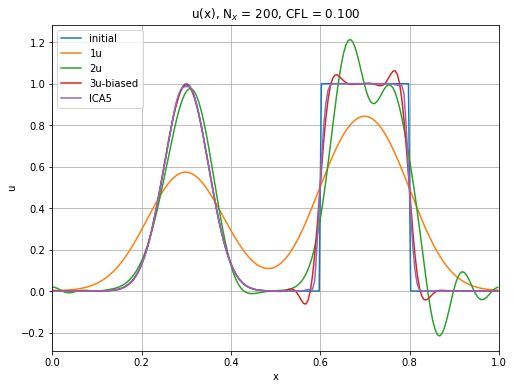

In [135]:
N = 200
x, u = init_step(N)

# advect
c = 1
dx = 1/N
dt = 0.1 * dx / c
N_steps = int(1 / c / dt)

u_1u = advect(x, u, c, dt, N_steps, first_order_upwind, RK3)
u_2u = advect(x, u, c, dt, N_steps, second_order_upwind, RK3)
u_2c = advect(x, u, c, dt, N_steps, second_order_centered, RK3)
u_3u = advect(x, u, c, dt, N_steps, third_order_upwind, RK3)
u_ICA5 = advect(x, u, c, dt, N_steps, ICA5, RK3)

# plot result
plt.plot(x,u,label='initial')
plt.plot(x,u_1u,label='1u')
plt.plot(x,u_2u,label='2u')
#plt.plot(x,u_2c,label='2c')
plt.plot(x,u_3u,label='3u-biased')
plt.plot(x,u_ICA5,label='ICA5')
plt.xlabel('x')
plt.ylabel('u')
plt.title('u(x), N$_x$ = %d, CFL = %.3f' % (N, c * dt / dx))
plt.xlim(0,1)
plt.grid()
plt.legend()
plt.show()

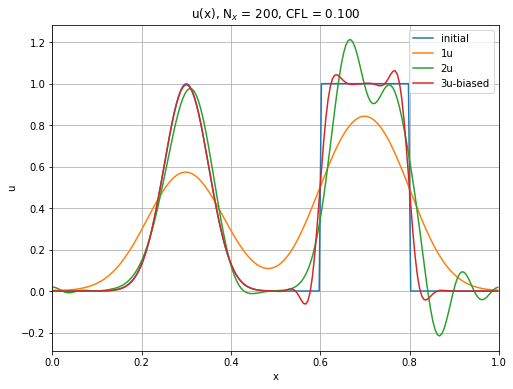

In [54]:
N = 200
x, u = init_step(N)

# advect
c = 1
dx = 1/N
dt = 0.1 * dx / c
N_steps = int(1 / c / dt)

u_1u = advect(x, u, c, dt, N_steps, first_order_upwind, RK3)
u_2u = advect(x, u, c, dt, N_steps, second_order_upwind, RK3)
u_2c = advect(x, u, c, dt, N_steps, second_order_centered, RK3)
u_3u = advect(x, u, c, dt, N_steps, third_order_upwind, RK3)

# plot result
plt.plot(x,u,label='initial')
plt.plot(x,u_1u,label='1u')
plt.plot(x,u_2u,label='2u')
#plt.plot(x,u_2c,label='2c')
plt.plot(x,u_3u,label='3u-biased')
plt.xlabel('x')
plt.ylabel('u')
plt.title('u(x), N$_x$ = %d, CFL = %.3f' % (N, c * dt / dx))
plt.xlim(0,1)
plt.grid()
plt.legend()
plt.show()

In [39]:
dt

1e-05

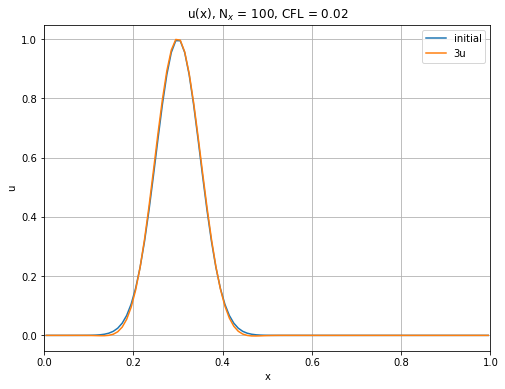

In [19]:
N = 100
x, u = init_smooth(N)

# advect
c = 1/2
dx = 1/N
dt = 1/50 * dx / c
N_steps = int(1 / c / dt)

u_1u = advect(x, u, c, dt, N_steps, first_order_upwind, forward_euler)
u_2u = advect(x, u, c, dt, N_steps, second_order_upwind, forward_euler)
u_2c = advect(x, u, c, dt, N_steps, second_order_centered, forward_euler)
u_3u = advect(x, u, c, dt, N_steps, third_order_upwind, forward_euler)

# plot result
plt.plot(x,u,label='initial')
#plt.plot(x,u_1u,label='1u')
#plt.plot(x,u_2u,label='2u')
#plt.plot(x,u_2c,label='2c')
plt.plot(x,u_3u,label='3u')
plt.xlabel('x')
plt.ylabel('u')
plt.title('u(x), N$_x$ = %d, CFL = %.2f' % (N, c * dt / dx))
plt.xlim(0,1)
plt.grid()
plt.legend()
plt.show()

In [20]:
print('\int u    dx = ', np.sum(u) * dx)
print('\int u_1u dx = ', np.sum(u_1u) * dx)
print('\int u_2u dx = ', np.sum(u_2u) * dx)
print('\int u_2c dx = ', np.sum(u_2c) * dx)
print('\int u_3u dx = ', np.sum(u_3u) * dx)

\int u    dx =  0.1240717694845932
\int u_1u dx =  0.12407176948459332
\int u_2u dx =  0.1240717694845932
\int u_2c dx =  0.12407176948459324
\int u_3u dx =  0.12407176948459321


In [28]:
def convergence_error(flux_method, step_method, ngrids, error_type):
    errors = np.zeros(np.size(ngrids))
    for ii, N in enumerate(ngrids):
        x, u = init_step(N)
        c = 1
        dx = 1 / N
        # CFL = 0.01
        dt = 0.01 * dx / c
        N_steps = int(1 / c / dt)
        u_end = advect(x, u, c, dt, N_steps, flux_method, step_method)
        error = np.abs(u_end - u)
        if error_type == 'max error':
            errors[ii] = np.max(error)
        elif error_type == 'L2 error':
            errors[ii] = np.sqrt(np.sum(error ** 2) / N)
    return errors

In [29]:
ngrids = np.array([100,200,400,600,1000,2000,4000])
errors = convergence_error(third_order_upwind, forward_euler, ngrids, 'L2 error')

Text(0.5, 1.0, 'Convergence, 3u-biased, CFL=0.01')

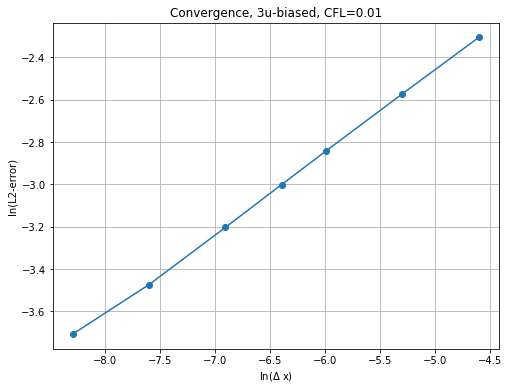

In [34]:
plt.plot(np.log(1/ngrids), np.log(errors), '-o')
plt.grid()
plt.xlabel('ln($\Delta$ x)')
plt.ylabel('ln(L2-error)')
plt.title('Convergence, 3u-biased, CFL=0.01')

#### Old code: 1st-order upwind

In [8]:
N = 100
x, u = init_step(N)

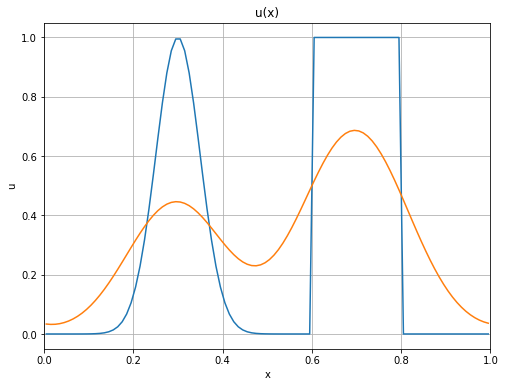

In [9]:
# advect
c = 1
dx = 1/N
dt = 0.01 * dx

N_steps = 1 / c / dt

u_next = u
for jj in range(1 * int(N_steps)):
    # flux
    u_mod = np.insert(u_next, 0, u_next[-1], axis = 0)
    f = c * u_mod

    # update the system
    u_next = u_next - (dt / dx) * (f[1:] - f[0:-1])

# plot result
# plot
plt.plot(x,u)
plt.plot(x,u_next)
plt.xlabel('x')
plt.ylabel('u')
plt.title('u(x)')
plt.xlim(0,1)
plt.grid()
plt.show()

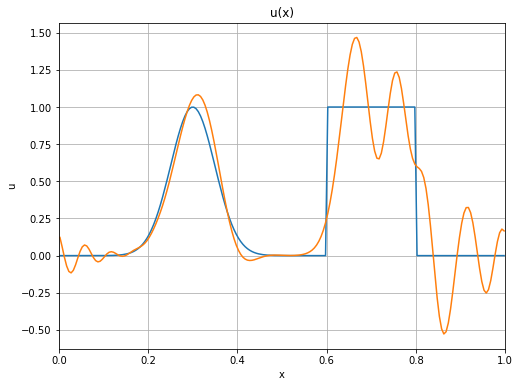

In [23]:
N = 200
x, u = init_step(N)

# advect
c = 1
dx = 1/N
dt = 0.1 * dx
N_steps = int(1 / c / dt)

u_next = u
for jj in range(int(N_steps)):
    # flux (at j+1/2)
    f = c * (u_next + 0.5 * (u_next - np.roll(u_next, 1)))

    # update the system
    u_next = u_next - (dt / dx) * (f - np.roll(f, 1))

# plot result
# plot
plt.plot(x,u)
plt.plot(x,u_next)
plt.xlabel('x')
plt.ylabel('u')
plt.title('u(x)')
plt.xlim(0,1)
plt.grid()
plt.show()

In [286]:
def mc_limiter(x, u, c):
    

1.0

#### How np.roll( ) works

In [277]:
b = np.arange(0,10)
print('original array')
print('      ', b)
print('--------------------------------------')
for ii in range(-9,10):
    print('%2d' % ii, ' : ', np.roll(b, ii))

original array
       [0 1 2 3 4 5 6 7 8 9]
--------------------------------------
-9  :  [9 0 1 2 3 4 5 6 7 8]
-8  :  [8 9 0 1 2 3 4 5 6 7]
-7  :  [7 8 9 0 1 2 3 4 5 6]
-6  :  [6 7 8 9 0 1 2 3 4 5]
-5  :  [5 6 7 8 9 0 1 2 3 4]
-4  :  [4 5 6 7 8 9 0 1 2 3]
-3  :  [3 4 5 6 7 8 9 0 1 2]
-2  :  [2 3 4 5 6 7 8 9 0 1]
-1  :  [1 2 3 4 5 6 7 8 9 0]
 0  :  [0 1 2 3 4 5 6 7 8 9]
 1  :  [9 0 1 2 3 4 5 6 7 8]
 2  :  [8 9 0 1 2 3 4 5 6 7]
 3  :  [7 8 9 0 1 2 3 4 5 6]
 4  :  [6 7 8 9 0 1 2 3 4 5]
 5  :  [5 6 7 8 9 0 1 2 3 4]
 6  :  [4 5 6 7 8 9 0 1 2 3]
 7  :  [3 4 5 6 7 8 9 0 1 2]
 8  :  [2 3 4 5 6 7 8 9 0 1]
 9  :  [1 2 3 4 5 6 7 8 9 0]


In [278]:
b

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [279]:
fb = first_order_upwind(b, b, 1)
fb

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [280]:
b_next = b - 0.1 * (fb - np.roll(fb, 1))
b_next

array([0.9, 0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9])

In [281]:
b_end = advect(b, b, 1, 0.001, 10000, second_order_upwind, forward_euler)
b_end

array([5.38763287, 4.01197318, 2.80822409, 2.24525989, 2.55468143,
       3.61945669, 5.01702486, 6.20260812, 6.73243674, 6.42070212])

In [282]:
np.sum(b_end)

45.00000000000007

In [305]:
minmod(1,6,4)

1.0

In [98]:
aa = np.array([1, 5, 9])
bb = np.array([7, 2, 6])
cc = np.array([8, 4, 3])

In [66]:
where = np.where(aa < bb)
where[0]

0

In [100]:
dd = np.copy(bb)
dd[where[0]] = aa[where[0]]
dd

array([1, 2, 6])

In [102]:
def vecmin(x, y, z = None):
    where = np.where(x < y)
    m = np.copy(y)
    m[where[0]] = x[where[0]]
    if z is None:
        return m
    else:
        where = np.where(m < z)
        n = np.copy(z)
        n[where[0]] = m[where[0]]
        return n

In [127]:
median(aa, bb, cc)

array([7., 4., 6.])

In [125]:
aa + minmod(bb-aa,cc-aa)

array([7., 4., 6.])

In [105]:
bb-aa

array([ 6, -3, -3])

In [106]:
cc-aa

array([ 7, -1, -6])

In [124]:
minmod(bb-aa,cc-aa)

array([ 6., -1., -3.])

In [101]:
bb

array([7, 2, 6])

In [122]:
minmin(aa, 4)

array([1., 4., 4.])